<a href="https://colab.research.google.com/github/crk00015/Final-project-team-13/blob/main/casey_group1_freak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import random
import time
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from torchvision import models, transforms
from torchvision.models import ConvNeXt_Tiny_Weights
import torch

categories = ["good", "poor", "satisfactory", "very_poor"]
label_map = {label: idx for idx, label in enumerate(categories)}

base_path = "/content/drive/MyDrive/Final Project 465/lab2/PICs/sih_road_dataset"
image_files, labels = [], []
for category in categories:
    cat_path = os.path.join(base_path, category)
    files = [os.path.join(cat_path, f) for f in os.listdir(cat_path)]
    sample = random.sample(files, min(150, len(files)))
    image_files += sample
    labels += [category] * len(sample)
train_files, temp_files, train_labels, temp_labels = train_test_split(image_files, labels, test_size=0.2, stratify=labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

fast = cv2.FastFeatureDetector_create()
freak = cv2.xfeatures2d.FREAK_create()

def extract_freak(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    kp = fast.detect(img, None)
    kp, des = freak.compute(img, kp)
    return np.mean(des, axis=0) if des is not None else np.zeros(64)

def compute_freak_features(paths, labels):
    features = []
    targets = []
    start_time = time.time()
    for i, (path, label) in enumerate(zip(paths, labels)):
        print(f"[{i+1}/{len(paths)}] Processing FREAK for: {os.path.basename(path)}")
        feat = extract_freak(path)
        features.append(feat)
        targets.append(label_map[label])
    return np.array(features), np.array(targets)

X_train_freak, y_train_freak = compute_freak_features(train_files, train_labels)
X_val_freak, y_val_freak = compute_freak_features(val_files, val_labels)
X_test_freak, y_test_freak = compute_freak_features(test_files, test_labels)

scaler_freak = StandardScaler()
X_train_freak = scaler_freak.fit_transform(X_train_freak)
X_val_freak = scaler_freak.transform(X_val_freak)
X_test_freak = scaler_freak.transform(X_test_freak)

print("Training SVM on FREAK features")
svm_freak = SVC(kernel='linear', probability=True)
svm_freak.fit(X_train_freak, y_train_freak)

convnext = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
convnext.classifier = torch.nn.Identity()
convnext.eval()
deep_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def extract_convnext_features(paths, labels):
    features = []
    targets = []
    start_time = time.time()
    for i, (path, label) in enumerate(zip(paths, labels)):
        print(f"[{i+1}/{len(paths)}] Extracting ConvNext features from: {os.path.basename(path)}")
        try:
            img = Image.open(path).convert("RGB")
            x = deep_transform(img).unsqueeze(0)
            with torch.no_grad():
                feat = convnext(x).squeeze().numpy()
            features.append(feat)
            targets.append(label_map[label])
        except Exception as e:
            print(f"Failed on {path}: {e}")
            features.append(np.zeros(768))
            targets.append(0)
    return np.array(features), np.array(targets)

X_train_cx, y_train_cx = extract_convnext_features(train_files, train_labels)
X_val_cx, y_val_cx = extract_convnext_features(val_files, val_labels)
X_test_cx, y_test_cx = extract_convnext_features(test_files, test_labels)

scaler_cx = StandardScaler()
X_train_cx = scaler_cx.fit_transform(X_train_cx)
X_val_cx = scaler_cx.transform(X_val_cx)
X_test_cx = scaler_cx.transform(X_test_cx)

print("Training SVM on ConvNeXt features")
svm_cx = SVC(kernel='linear', probability=True)
svm_cx.fit(X_train_cx, y_train_cx)

def evaluate_svm(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, average='macro'),
        "recall": recall_score(y, preds, average='macro'),
        "f1": f1_score(y, preds, average='macro')
    }

print("Results")
print("FREAK and SVM:", evaluate_svm(svm_freak, X_test_freak, y_test_freak))
print("ConvNext and SVM:", evaluate_svm(svm_cx, X_test_cx, y_test_cx))


[1/457] Processing FREAK for: good_438.JPG
[2/457] Processing FREAK for: good_446.JPG
[3/457] Processing FREAK for: poor_017.jpg
[4/457] Processing FREAK for: satis_325.jpg
[5/457] Processing FREAK for: good_548.JPG
[6/457] Processing FREAK for: poor_101.jpg
[7/457] Processing FREAK for: verypoor_026.jpg
[8/457] Processing FREAK for: poor_363.jpg
[9/457] Processing FREAK for: poor_293.jpg
[10/457] Processing FREAK for: poor_212.jpg
[11/457] Processing FREAK for: good_171.JPG
[12/457] Processing FREAK for: good_034.JPG
[13/457] Processing FREAK for: poor_036.jpg
[14/457] Processing FREAK for: satis_313.jpg
[15/457] Processing FREAK for: good_301.JPG
[16/457] Processing FREAK for: poor_256.jpg
[17/457] Processing FREAK for: satis_132.jpg
[18/457] Processing FREAK for: satis_439.jpg
[19/457] Processing FREAK for: satis_164.jpg
[20/457] Processing FREAK for: good_309.JPG
[21/457] Processing FREAK for: good_252.JPG
[22/457] Processing FREAK for: verypoor_180.jpg
[23/457] Processing FREAK fo

Training SVM on FREAK features


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 142MB/s]


Training SVM on ConvNeXt features
Results
FREAK and SVM: {'accuracy': 0.7931034482758621, 'precision': 0.823076923076923, 'recall': 0.7923076923076924, 'f1': 0.7995341614906831}
ConvNeXt and SVM: {'accuracy': 0.9655172413793104, 'precision': 0.9705882352941176, 'recall': 0.9666666666666667, 'f1': 0.9665178571428572}


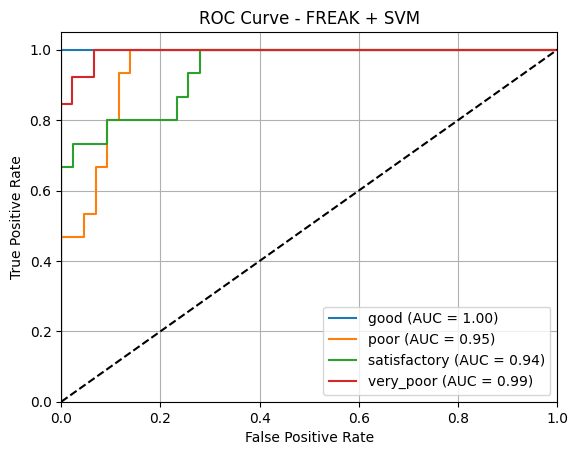

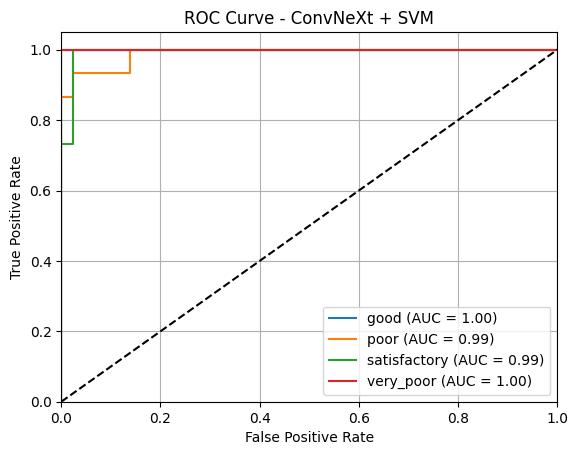

In [2]:
import os
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from torchvision import models, transforms
from torchvision.models import ConvNeXt_Tiny_Weights
import torch

categories = ["good", "poor", "satisfactory", "very_poor"]
label_map = {label: idx for idx, label in enumerate(categories)}

base_path = "/content/drive/MyDrive/Final Project 465/lab2/PICs/sih_road_dataset"
image_files, labels = [], []
for category in categories:
    cat_path = os.path.join(base_path, category)
    files = [os.path.join(cat_path, f) for f in os.listdir(cat_path)]
    sample = random.sample(files, min(150, len(files)))
    image_files += sample
    labels += [category] * len(sample)
train_files, temp_files, train_labels, temp_labels = train_test_split(image_files, labels, test_size=0.2, stratify=labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

fast = cv2.FastFeatureDetector_create()
freak = cv2.xfeatures2d.FREAK_create()

def extract_freak(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    kp = fast.detect(img, None)
    kp, des = freak.compute(img, kp)
    return np.mean(des, axis=0) if des is not None else np.zeros(64)

def compute_features(paths, labels, extractor):
    features = []
    targets = []
    for path, label in zip(paths, labels):
        feat = extractor(path)
        features.append(feat)
        targets.append(label_map[label])
    return np.array(features), np.array(targets)

X_train_freak, y_train_freak = compute_features(train_files, train_labels, extract_freak)
X_val_freak, y_val_freak = compute_features(val_files, val_labels, extract_freak)
X_test_freak, y_test_freak = compute_features(test_files, test_labels, extract_freak)

scaler_freak = StandardScaler()
X_train_freak = scaler_freak.fit_transform(X_train_freak)
X_val_freak = scaler_freak.transform(X_val_freak)
X_test_freak = scaler_freak.transform(X_test_freak)

print("Training SVM on FREAK features")
svm_freak = OneVsRestClassifier(SVC(kernel='linear', probability=True))
svm_freak.fit(X_train_freak, y_train_freak)

convnext = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
convnext.classifier = torch.nn.Identity()
convnext.eval()
deep_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def extract_convnext_features(paths, labels):
    features = []
    targets = []
    for path, label in zip(paths, labels):
        try:
            img = Image.open(path).convert("RGB")
            x = deep_transform(img).unsqueeze(0)
            with torch.no_grad():
                feat = convnext(x).squeeze().numpy()
            features.append(feat)
            targets.append(label_map[label])
        except:
            features.append(np.zeros(768))
            targets.append(0)
    return np.array(features), np.array(targets)

X_train_cx, y_train_cx = extract_convnext_features(train_files, train_labels)
X_val_cx, y_val_cx = extract_convnext_features(val_files, val_labels)
X_test_cx, y_test_cx = extract_convnext_features(test_files, test_labels)

scaler_cx = StandardScaler()
X_train_cx = scaler_cx.fit_transform(X_train_cx)
X_val_cx = scaler_cx.transform(X_val_cx)
X_test_cx = scaler_cx.transform(X_test_cx)

print("Training SVM on ConvNeXt features")
svm_cx = OneVsRestClassifier(SVC(kernel='linear', probability=True))
svm_cx.fit(X_train_cx, y_train_cx)

def evaluate_svm(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, average='macro'),
        "recall": recall_score(y, preds, average='macro'),
        "f1": f1_score(y, preds, average='macro')
    }

def plot_roc(model, X, y, title):
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y)
    y_score = model.predict_proba(X)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], y_score[:, i])
    plt.figure()
    for i in range(len(categories)):
        plt.plot(fpr[i], tpr[i], label=f"{categories[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

print("Results")
print("FREAK and SVM:", evaluate_svm(svm_freak, X_test_freak, y_test_freak))
print("ConvNeXt and SVM:", evaluate_svm(svm_cx, X_test_cx, y_test_cx))

plot_roc(svm_freak, X_test_freak, y_test_freak, "FREAK + SVM")
plot_roc(svm_cx, X_test_cx, y_test_cx, "ConvNeXt + SVM")
